# Трансферное обучение на примере распознавания фотографий кошек и собак

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # Генератор обучающих данных
from tensorflow.keras.models import Sequential      # Контейнер модели
from tensorflow.keras.layers import Input, Flatten, Dense  # Типы используемых слоев
from tensorflow.keras.optimizers import Adam    # Алгоритм оптимизации
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [ ]:
# Список предобученных моделей можно получить так
import tensorflow as tf
dir(tf.keras.applications)

Подготовка данных:

In [ ]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset.zip"
LOCAL_DIR = '/content'

# Распаковка архива в сессионное хранилище
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
# Если архив уже распакован на Google диск, то можно скопировать директорию в сессионное хранилище
DRIVE_DIR = '/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset'
shutil.copytree(DRIVE_DIR, os.path.join(LOCAL_DIR, 'dataset'))

In [ ]:
TRAIN_DIR = os.path.join(LOCAL_DIR, 'dataset/train')
TEST_DIR = os.path.join(LOCAL_DIR, 'dataset/test')

In [ ]:
# Определяем генераторы обучающих и тестовых данных
# Аугментация не используется, но можно включить
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Загрузка предобученной модели VGG19:

In [ ]:
# Сохраняем предобученную модель в переменную conv_base
conv_base = VGG19(include_top=False,
                  weights='imagenet',
                  input_shape=(150, 150, 3)
                  )

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Построение модели с предобученной основой VGG19:

In [ ]:
model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(conv_base)  # предобученная модель
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Замораживаем предобученную модель
conv_base.trainable = False

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,122,049 (84.39 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Компиляция и запуск обучения модели
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=20,
      validation_data=test_generator)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.9908 - loss: 0.0519 - val_accuracy: 0.8880 - val_loss: 0.2812
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.9920 - loss: 0.0447 - val_accuracy: 0.8890 - val_loss: 0.3046
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - accuracy: 0.9940 - loss: 0.0412 - val_accuracy: 0.8860 - val_loss: 0.2887
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - accuracy: 0.9979 - loss: 0.0273 - val_accuracy: 0.8950 - val_loss: 0.2931
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 391ms/step - accuracy: 0.9995 - loss: 0.0206 - val_accuracy: 0.8840 - val_loss: 0.2999
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.9995 - loss: 0.0192 - val_accuracy: 0.8920 - val_loss: 0.3094
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.8860 - val_loss: 0.3142
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accu

In [ ]:
# Можно разморозить предобученную модель и продолжить обучение с небольшим learning_rate
conv_base.trainable = True
# Компиляция и запуск обучения модели
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00005),
              metrics=['accuracy'])
history2 = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      validation_data=test_generator)

Epoch 1/10
40/50 ━━━━━━━━━━━━━━━━━━━━ 9s 933ms/step - accuracy: 0.8801 - loss: 0.4209 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 845ms/step - accuracy: 0.8862 - loss: 0.3901 - val_accuracy: 0.9570 - val_loss: 0.1170
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 890ms/step - accuracy: 0.9808 - loss: 0.0559 - val_accuracy: 0.9470 - val_loss: 0.1376
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 847ms/step - accuracy: 0.9957 - loss: 0.0169 - val_accuracy: 0.9580 - val_loss: 0.1172
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 844ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9660 - val_loss: 0.1169
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9700 - val_loss: 0.1164
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 828ms/step - accuracy: 1.0000 - loss: 4.5095e-04 - val_accuracy: 0.9680 - val_loss: 0.1212
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 839ms/step - accuracy: 1.0000 - loss: 2.0477e-04 - val_accuracy: 0.9700 - val_loss: 0.1196
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 867ms/step - accuracy: 1.0000 - loss: 1.4208e-04 - val_ac

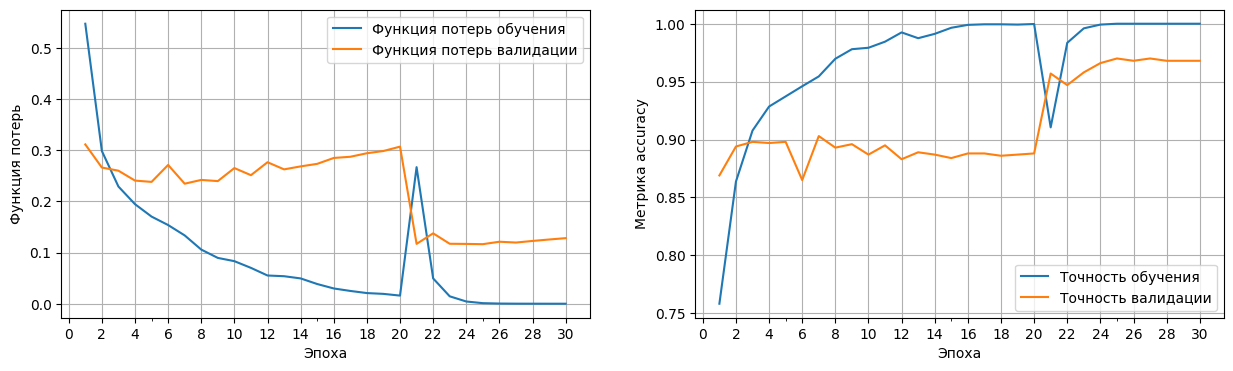

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(np.arange(1, len(history.history['loss'] + history2.history['loss']) + 1), history.history['loss'][:]  + history2.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history['loss'] + history2.history['loss']) + 1), history.history['val_loss'][:] + history2.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history['loss'] + history2.history['loss']) + 1, 2))
axs[0].set_xticks(np.arange(0, len(history.history['loss'] + history2.history['loss']) + 1, 5), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history['accuracy'] + history2.history['accuracy']) + 1), history.history['accuracy'][:] + history2.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history['accuracy'] + history2.history['accuracy']) + 1), history.history['val_accuracy'][:] + history2.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history['accuracy'] + history2.history['accuracy']) + 1, 2))
axs[1].set_xticks(np.arange(0, len(history.history['accuracy'] + history2.history['accuracy']) + 1, 5), minor=True)
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()

Итоговая точность достигла уровня 97% против 80% у модели, разработанной с нуля. Использование предобученных моделей рекомендуется при обработке фотореалистичных изображений.

Также можно использовать ранее описанные методы улучшения качества классификации: аугментация, dropout, BatchNorm.